# Script to compare examples of days from each season

In [1]:
import pandas as pd
from matplotlib import pyplot as plt, dates
from datetime import timedelta
import numpy as np
import os
import sys

In [2]:
Solcast_Path = '../Private_Data/Solcast/Solcast_Formatted.csv'
Public = False

# Checking if the necessary files exist for formatting.
if not os.path.exists(Solcast_Path):
    print(f"Warning: This script will not have full functionality without the formatted Solcast data in {Solcast_Path}`.\n",
          'Please download the data from `solcast.com` at 5 minute cadence for all of 2023.\n',
          'Then run the script in `Scripts/Utils/Format_Solcast.ipynb` to format the data.')
    Public = True

## Loading data

In [3]:
DEOP = pd.read_csv('../Data/DEOP/2023_DEOP_Interp.csv',
                    parse_dates=['DateTime'],
                    index_col=['DateTime']).astype(float)

if Public is False:
    Solcast = pd.read_csv(Solcast_Path,
                    parse_dates=['DateTime'],
                    index_col=['DateTime']).astype(float)

    Power_Expectation_Path = '../Private_Data/Solcast/Power_Expectation.csv'

    if not os.path.exists(Power_Expectation_Path):
        sys.exit(f"Warning: This script will not run without the processed data in {Power_Expectation_Path}`.\n \
                 To create this file, please run the script at `Scripts/Renewable_Energy_Efficiency.ipynb`.")
    else:
        Power_Expectation = pd.read_csv(Power_Expectation_Path,
                            parse_dates=['DateTime'],
                            index_col=['DateTime']).astype(float)

        Solcast = pd.concat([Power_Expectation,Solcast],axis=1)
else:
    Solcast = None

In [ ]:
# Load calculated efficiencies.
stats = pd.read_csv('../Data/Analysis/Data_Tables/csv/statistics.csv',index_col=0)

In [5]:
##Spring##
DEOP_Spring = DEOP.loc[(DEOP.index >= '2023-03-01 00:00')
                      & (DEOP.index < '2023-05-31 23:59')]
DEOP_Spring = DEOP_Spring.resample('h').var().to_period('h').to_timestamp() # variance per hour
DEOP_Spring = DEOP_Spring.resample('D').sum().to_period('D').to_timestamp() # which day has the greatest variance per hour?

##Summer##
if Public is False:
    Solcast_Summer = Solcast.loc[(Solcast.index >= '2023-06-01 00:00')
                        & (Solcast.index < '2023-08-31 23:59')]

    Solcast_Summer = Solcast_Summer.resample('D').sum().to_period('D').to_timestamp()

    ##Autumn##
    Solcast_Autumn = Solcast.loc[(Solcast.index >= '2023-09-01 00:00')
                        & (Solcast.index < '2023-11-30 23:59')]

    Solcast_Autumn = Solcast_Autumn.resample('D').mean().to_period('D').to_timestamp()
    Solcast_Autumn['Wind_Rank'] = Solcast_Autumn['wind_speed_100m'].rank(method='min').astype(int)
    Solcast_Autumn['Sun_Rank'] = Solcast_Autumn['gti'].rank(method='min',ascending=False).astype(int)
    Solcast_Autumn['SunWind_Rank'] = Solcast_Autumn['Wind_Rank'] * Solcast_Autumn['Sun_Rank']

    ##Winter##
    Solcast_Winter = Solcast.loc[((Solcast.index >= '2023-01-01 00:00')
                        & (Solcast.index < '2023-02-28 23:59'))|((Solcast.index >= '2023-12-01 00:00')
                        & (Solcast.index < '2023-12-31 23:59'))]

    Solcast_Winter = Solcast_Winter.resample('D').sum().to_period('D').to_timestamp()

In [6]:
SpringDay = DEOP_Spring[['power-gen-pv-ave']].idxmax()

if Public is False:
    SummerDay = Solcast_Summer[['gti']].idxmax()
    WinterDay = Solcast_Winter[['gti']].idxmax()
    AutumnDay = Solcast_Autumn[['SunWind_Rank']].idxmax()

else:
    SummerDay = [np.datetime64('2023-06-14')]
    WinterDay = [np.datetime64('2023-02-23')]
    AutumnDay = [np.datetime64('2023-10-20')]

In [ ]:
def PlotSeasonal(Public,eta_wind,eta_sun,DEOP,Solcast,Day,fig_name,loc=None,save_fig=False):
    """
    Function plotting seasonal examples of data

    Parameters
    ----------
    Public : boolean
        If True, it will be run using the public verison
        If False, it will be run using the private verison
    eta_wind : float
        Efficiency of wind turbines.
    eta_sun : float
        Efficiency of solar panels.
    DEOP : pd.DataFrame
        DEOP data.
    Solcast : pd.DataFrame
        Solcast data.
    Day : datetime
        Beginning of the day of interest.
    fig_name : str
        Name under which the figure will be saved.
    loc : float or string
        location of legend
        Defaults to None
    save_fig : boolean
        If True, the figure is saved. 
        If False, the figure is not saved.
        Defaults to False
    """
    EndDay = Day + timedelta(hours=24)

    DEOP_Day = DEOP.loc[(DEOP.index >= Day.values[0])
                     & (DEOP.index < EndDay.values[0])]
    
    if Public is False:
        Solcast_Day = Solcast.loc[(DEOP.index >= Day.values[0])
                     & (DEOP.index < EndDay.values[0])]
    
    fig, ax1 = plt.subplots()

    ax1.plot(DEOP_Day.index,DEOP_Day['power-gen-pv-ave']/1e3,label='True Solar',ls='-',c='#E69F00')
    ax1.plot(DEOP_Day.index,DEOP_Day['power-gen-wt-ave']/1e3,label='True Wind',ls='-',c='#0072B2')
    ax1.plot(DEOP_Day.index,DEOP_Day['power-con-ave']/1e3,label='Consumption',ls='-',c='k')
    if Public is False:
        ax1.plot(Solcast_Day.index,Solcast_Day['P_KEWind']*eta_wind/1e3,label='Wind Expectation',ls='dashed',c='#D55E00')
        ax1.plot(Solcast_Day.index,Solcast_Day['P_MaxSolar']*eta_sun/1e3,label='Solar Expectation',ls='dotted',c='#009E73')

    ax1.set_xlabel('Time')
    ax1.set_ylabel('Power [MW]')

    ax1.xaxis.set_major_formatter(dates.DateFormatter('%H:%M')) # formatting the date
    ax1.set_xlim(Day,EndDay)

    ax1.tick_params(axis='both', direction='in',labelleft=True,labelright=True,left=True,right=True)

    ax1.legend(loc=loc)
    ax1.set_ylim(bottom=0)
    fig.autofmt_xdate()
    fig.tight_layout()
    
    if save_fig is True:
        fig.savefig(f'../Figures/pdf/{fig_name}.pdf')
        ax1.set_title(f'{Day.iloc[0].strftime('%A %d %B %Y').lstrip('0')}')  
        fig.tight_layout() 
        fig.savefig(f'../Figures/png/{fig_name}.png')

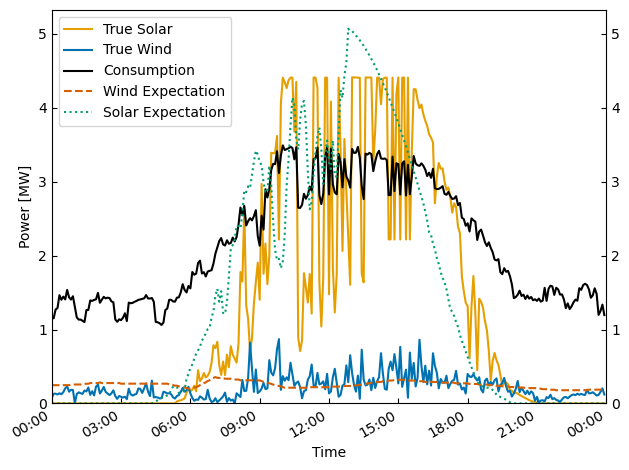

In [ ]:
PlotSeasonal(Public,stats.loc['eta_Wind','mean'],stats.loc['eta_Solar','mean'],DEOP,Solcast,SpringDay,'Seasonal_Plot_Spring')

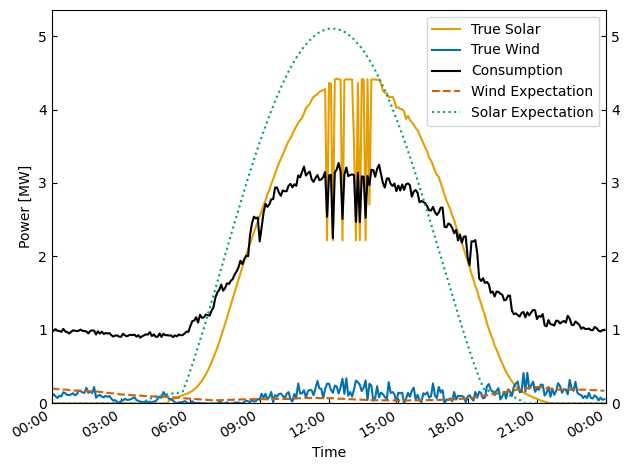

In [ ]:
PlotSeasonal(Public,stats.loc['eta_Wind','mean'],stats.loc['eta_Solar','mean'],DEOP,Solcast,SummerDay,'Seasonal_Plot_Summer')

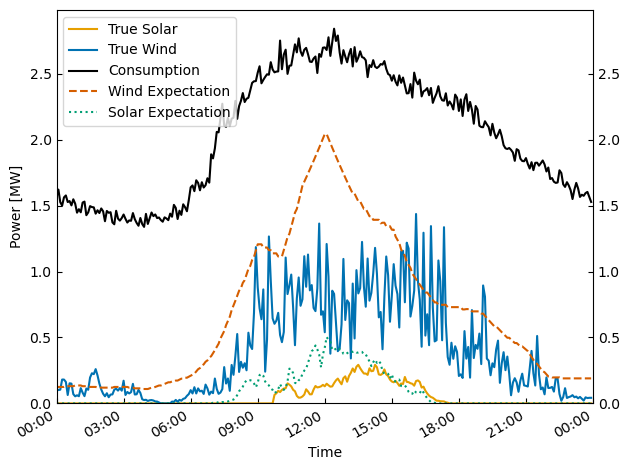

In [ ]:
PlotSeasonal(Public,stats.loc['eta_Wind','mean'],stats.loc['eta_Solar','mean'],DEOP,Solcast,AutumnDay,'Seasonal_Plot_Autumn')

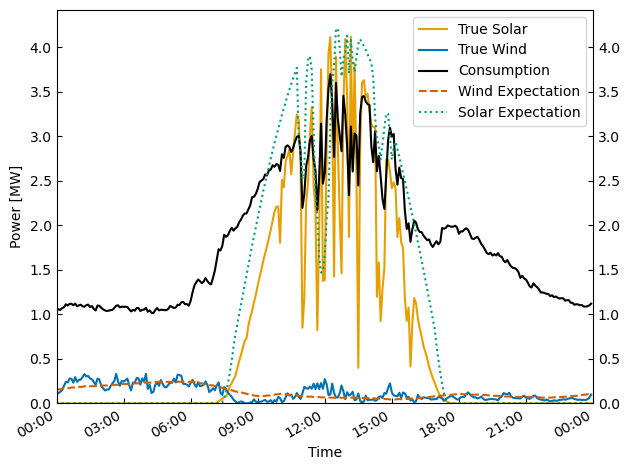

In [ ]:
PlotSeasonal(Public,stats.loc['eta_Wind','mean'],stats.loc['eta_Solar','mean'],DEOP,Solcast,WinterDay,'Seasonal_Plot_Winter')